<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

## 1. Problem Statement

- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

## 2. Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## 3. Type of Machine Leaning Problem

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

## 4. Performance Metrics/Key Performance Indicators

1. log-loss
2. Binary Confusion Matrix

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import distance
from fuzzywuzzy import fuzz
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from os import path
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm


# source
# https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import pickle
from collections import Counter
import numpy as np
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swatisharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 5. Identifying datapoints, features and class 

In [2]:
df_train = pd.read_csv("train.csv")
print("Total number of datapoints: ", df_train.shape[0])
print("\nColumns of dataset: ", df_train.columns)
print("\nDatapoints for each class: ")
print(df_train['is_duplicate'].value_counts())

Total number of datapoints:  404290

Columns of dataset:  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

Datapoints for each class: 
0    255027
1    149263
Name: is_duplicate, dtype: int64


There are 404290 datapoints in the entire dataset. There are 6 columns, 5 being the $x_i$ and is_duplicate being the $y_i$. $y_i$=0 has 255027 datapoints and $y_i$=1 has 149263 datapoints.

### Distribution of data points among output classes

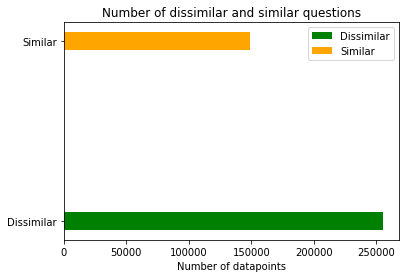

In [3]:
# Ref: https://stackoverflow.com/questions/23317150/python-matplotlib-legend-shows-first-entry-of-a-list-only

xi_bar = ['Dissimilar', 'Similar']
yi_bar = [255027, 149263]
color=['green', 'orange']
width = 0.1

fig, ax = plt.subplots()

for x, y, c, l in zip(xi_bar, yi_bar, color, xi_bar):
    ax.barh(x, y, width, color=c,label=l)
    
ax.set_title('Number of dissimilar and similar questions')
ax.set_xlabel('Number of datapoints')
ax.legend()
plt.show()

In [4]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Here question1 has 404289 and question2 has 404288 rows of non-null while all other columns have 404290 rows of non-null. So, we need to do some pre-processing to remove the non-null value in that $x_i$.

We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

In [6]:
print('Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df_train['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 
q_vals=qids.value_counts()
q_vals=q_vals.values

Question pairs are not Similar (is_duplicate = 0):
   63.08%
Question pairs are Similar (is_duplicate = 1):
   36.92%
Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



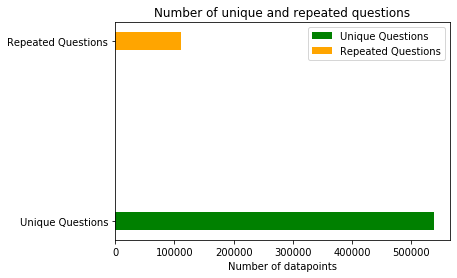

In [7]:
# Ref: https://stackoverflow.com/questions/23317150/python-matplotlib-legend-shows-first-entry-of-a-list-only

xi_bar2 = ["Unique Questions" , "Repeated Questions"]
yi_bar2 =  [unique_qs , qs_morethan_onetime]
color=['green', 'orange']
width = 0.1

fig, ax = plt.subplots()

for x, y, c, l in zip(xi_bar2, yi_bar2, color, xi_bar2):
    ax.barh(x, y, width, color=c,label=l)
    
ax.set_title('Number of unique and repeated questions')
ax.set_xlabel('Number of datapoints')
ax.legend()
plt.show()

### Checking for Duplicates

In [8]:
pair_duplicates = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df_train.shape[0])

Number of duplicate questions 0


### Number of occurrences of each question

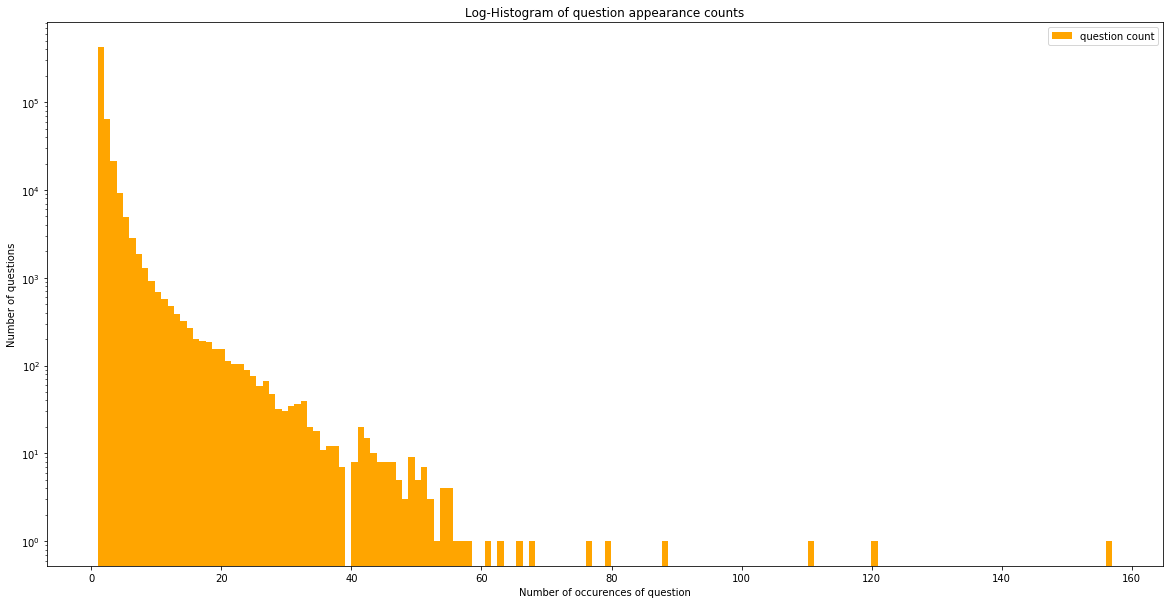

Maximum number of times a single question is repeated: 157



In [9]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160, log=True, color='orange', label='question count')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.legend()
plt.show()

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### Checking for NULL values

In [10]:
#Checking whether there are any rows with null values
nan_rows = df_train[df_train.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [11]:
# Filling the null values with ' '
df_train = df_train.fillna('')
nan_rows = df_train[df_train.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 6. Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [13]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df_w_o_pre_pro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df_w_o_pre_pro['freq_qid1'] = df_train.groupby('qid1')['qid1'].transform('count') 
    df_w_o_pre_pro['freq_qid2'] = df_train.groupby('qid2')['qid2'].transform('count')
    df_w_o_pre_pro['q1len'] = df_train['question1'].str.len() 
    df_w_o_pre_pro['q2len'] = df_train['question2'].str.len()
    df_w_o_pre_pro['q1_n_words'] = df_train['question1'].apply(lambda row: len(row.split(" ")))
    df_w_o_pre_pro['q2_n_words'] = df_train['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df_w_o_pre_pro['word_Common'] = df_train.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df_w_o_pre_pro['word_Total'] = df_train.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df_w_o_pre_pro['word_share'] = df_train.apply(normalized_word_share, axis=1)

    df_w_o_pre_pro['freq_q1+q2'] = df_w_o_pre_pro['freq_qid1']+df_w_o_pre_pro['freq_qid2']
    df_w_o_pre_pro['freq_q1-q2'] = abs(df_w_o_pre_pro['freq_qid1']-df_w_o_pre_pro['freq_qid2'])

    df_w_o_pre_pro.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df_w_o_pre_pro.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [14]:
df_w_o_pre_pro.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

### Analysis of some of the extracted features
- Here are some questions have only one single words.

In [15]:
print ("Minimum length of the questions in question1 : " , min(df_w_o_pre_pro['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df_w_o_pre_pro['q2_n_words']))
print ("Number of Questions with minimum length [question1] :", df_w_o_pre_pro[df_w_o_pre_pro['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df_w_o_pre_pro[df_w_o_pre_pro['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


### Feature: word_share

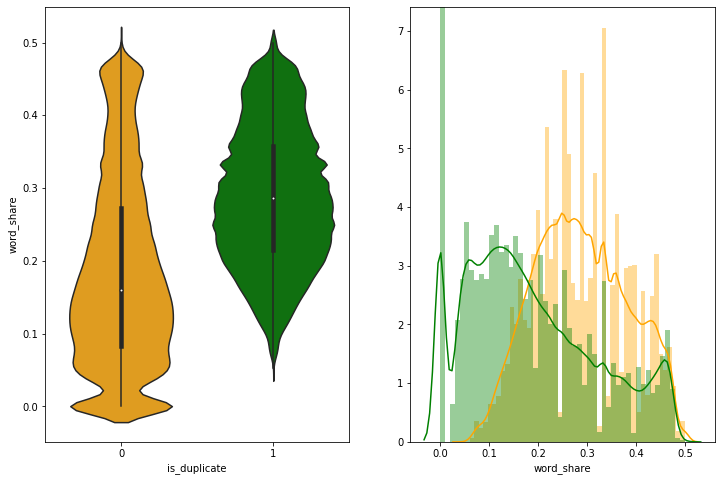

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df_w_o_pre_pro[0:], palette=['orange', 'green'])
plt.subplot(1,2,2)
sns.distplot(df_w_o_pre_pro[df_w_o_pre_pro['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'orange')
sns.distplot(df_w_o_pre_pro[df_w_o_pre_pro['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'green' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

### Feature: word_Common

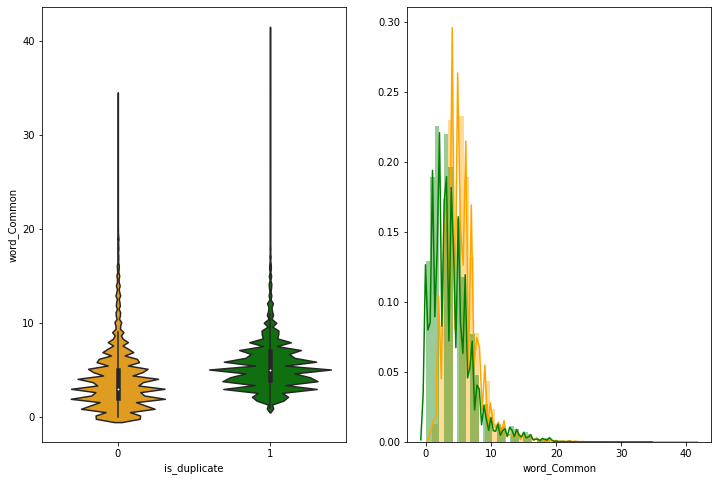

In [17]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df_w_o_pre_pro[0:], palette=['orange', 'green'])
plt.subplot(1,2,2)
sns.distplot(df_w_o_pre_pro[df_w_o_pre_pro['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'orange')
sns.distplot(df_w_o_pre_pro[df_w_o_pre_pro['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'green' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## 7. Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [18]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [19]:
preprocessed_question1 = list()
# tqdm is for printing the status bar
for q1 in tqdm(df_w_o_pre_pro['question1'].values):
    p1 = preprocess(q1)
    p1 = p1.replace('\\r', ' ')
    p1 = p1.replace('\\"', ' ')
    p1 = p1.replace('\\n', ' ')
    p1 = re.sub('[^A-Za-z0-9]+', ' ', p1)
    # https://gist.github.com/sebleier/554280
    p1 = ' '.join(e for e in p1.split() if e.lower() not in STOPWORDS)
    preprocessed_question1.append(p1.lower().strip())
df_w_o_pre_pro['clean_question1'] = preprocessed_question1

100%|██████████| 404290/404290 [06:19<00:00, 1065.97it/s]


In [20]:
preprocessed_question2 = list()
# tqdm is for printing the status bar
for q2 in tqdm(df_w_o_pre_pro['question2'].values):
    p2 = preprocess(q2)
    p2 = p2.replace('\\r', ' ')
    p2 = p2.replace('\\"', ' ')
    p2 = p2.replace('\\n', ' ')
    p2 = re.sub('[^A-Za-z0-9]+', ' ', p2)
    # https://gist.github.com/sebleier/554280
    p2 = ' '.join(e for e in p2.split() if e.lower() not in STOPWORDS)
    preprocessed_question2.append(p2.lower().strip())
df_w_o_pre_pro['clean_question2'] = preprocessed_question2

100%|██████████| 404290/404290 [06:13<00:00, 1083.78it/s]


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

## 8. Advanced Feature Extraction (NLP and Fuzzy Features)
Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [21]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [22]:
if os.path.isfile('nlp_features_train.csv'):
    df_nlp_feat_train = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df_nlp_feat_train.fillna('')
else:
    print("Extracting features for train:")
    df_nlp_feat_train = pd.read_csv("train.csv")
    df_nlp_feat_train = extract_features(df_nlp_feat_train)
    df_nlp_feat_train.to_csv("nlp_features_train.csv", index=False)
df_nlp_feat_train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [42]:
df_w_o_pre_pro = df_w_o_pre_pro.drop(['question1', 'question2', 'is_duplicate'], axis=1)

In [43]:
df_w_o_pre_pro.columns

Index(['id', 'qid1', 'qid2', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'clean_question1', 'clean_question2'],
      dtype='object')

In [44]:
df_nlp_feat_train = df_nlp_feat_train.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1)

In [45]:
df_nlp_feat_train.columns

Index(['id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [46]:
df_final = pd.merge(df_w_o_pre_pro, df_nlp_feat_train, on='id')

In [48]:
df_final.columns

Index(['id', 'qid1', 'qid2', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'clean_question1', 'clean_question2',
       'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

### Analysis of Extracted Features
- Plotting Word clouds
    - Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
    - We can observe the most frequent occuring words

In [50]:
df_duplicate = df_final[df_final['is_duplicate'] == 1]
dfp_nonduplicate = df_final[df_final['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["clean_question1"], df_duplicate["clean_question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["clean_question1"], dfp_nonduplicate["clean_question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [51]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 9808918
Total number of words in non duplicate pair questions : 20573407


### Word Clouds generated from  duplicate pair question's text

Word Cloud for Duplicate Question pairs


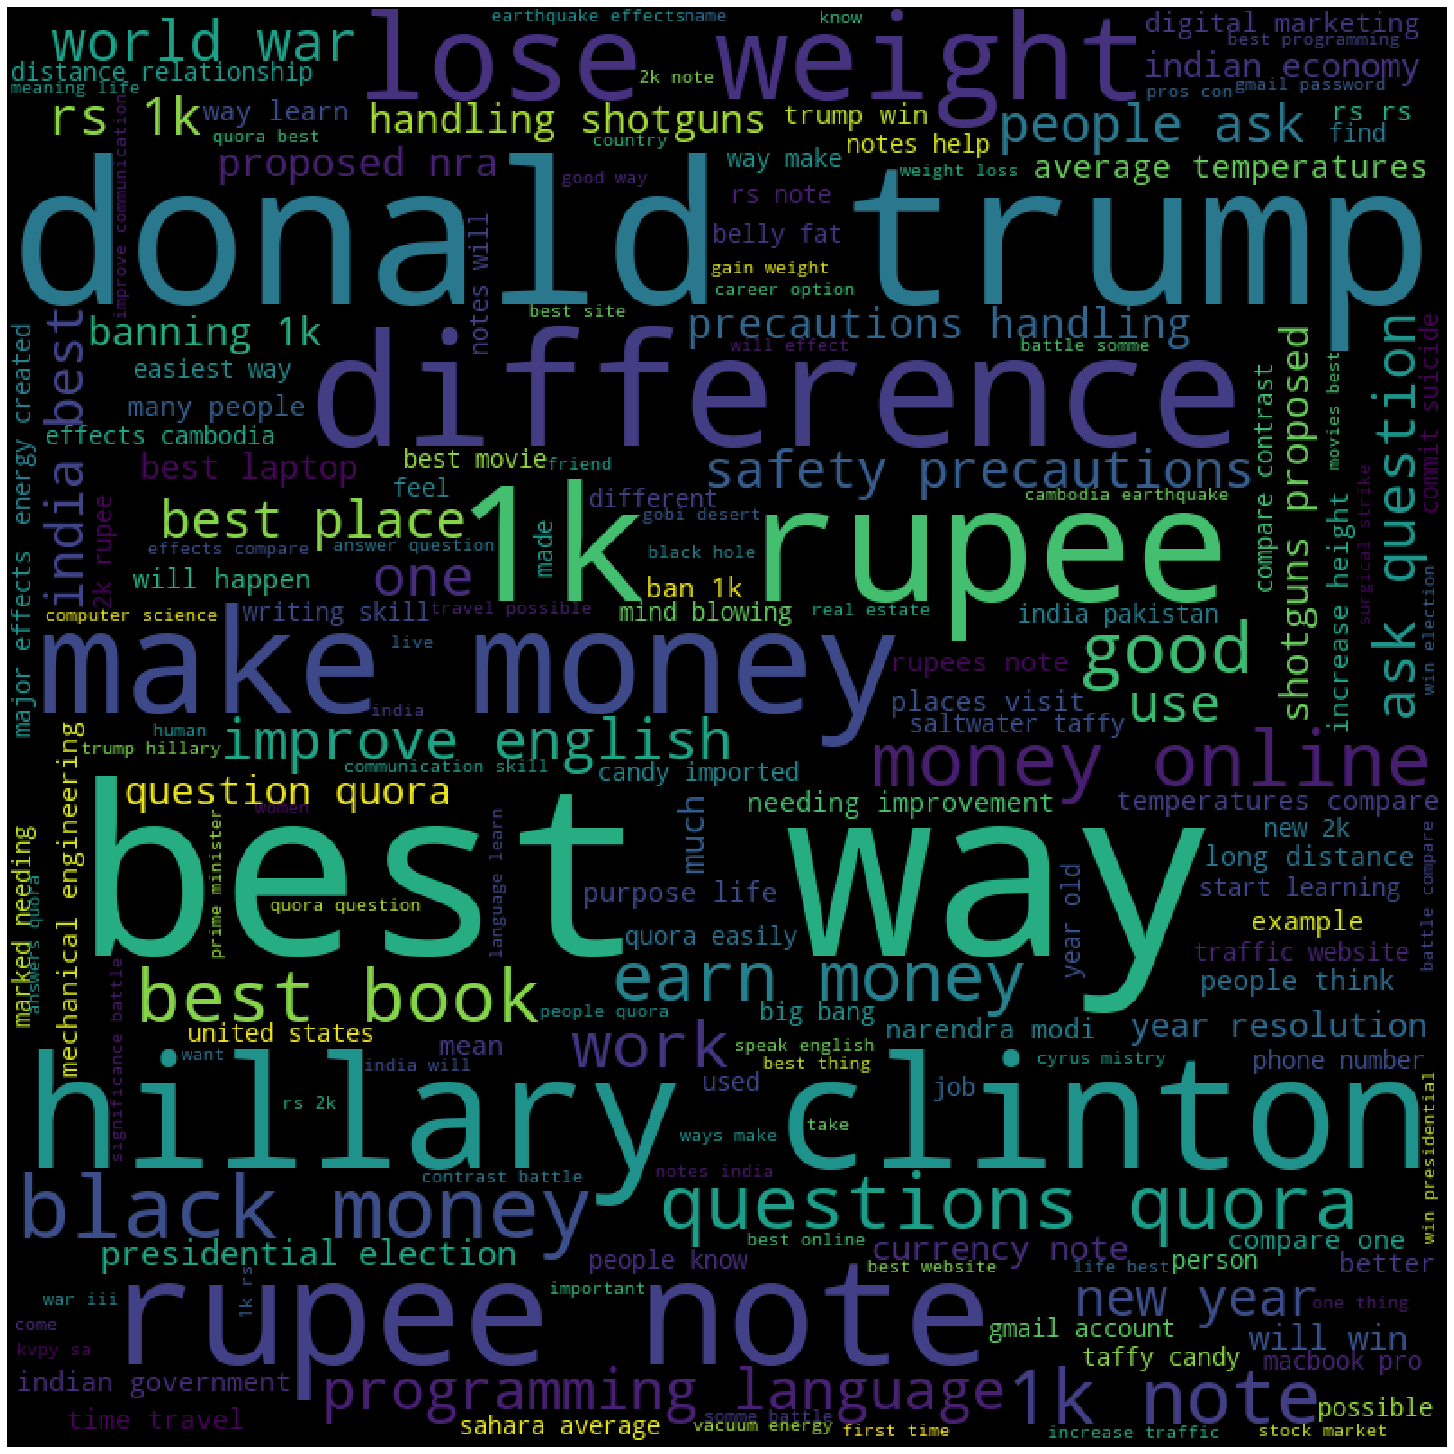

In [52]:
wc = WordCloud(width = 800, height = 800, background_color="black", min_font_size = 10, max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wc)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### Word Clouds generated from non duplicate pair question's text

Word Cloud for non-Duplicate Question pairs:


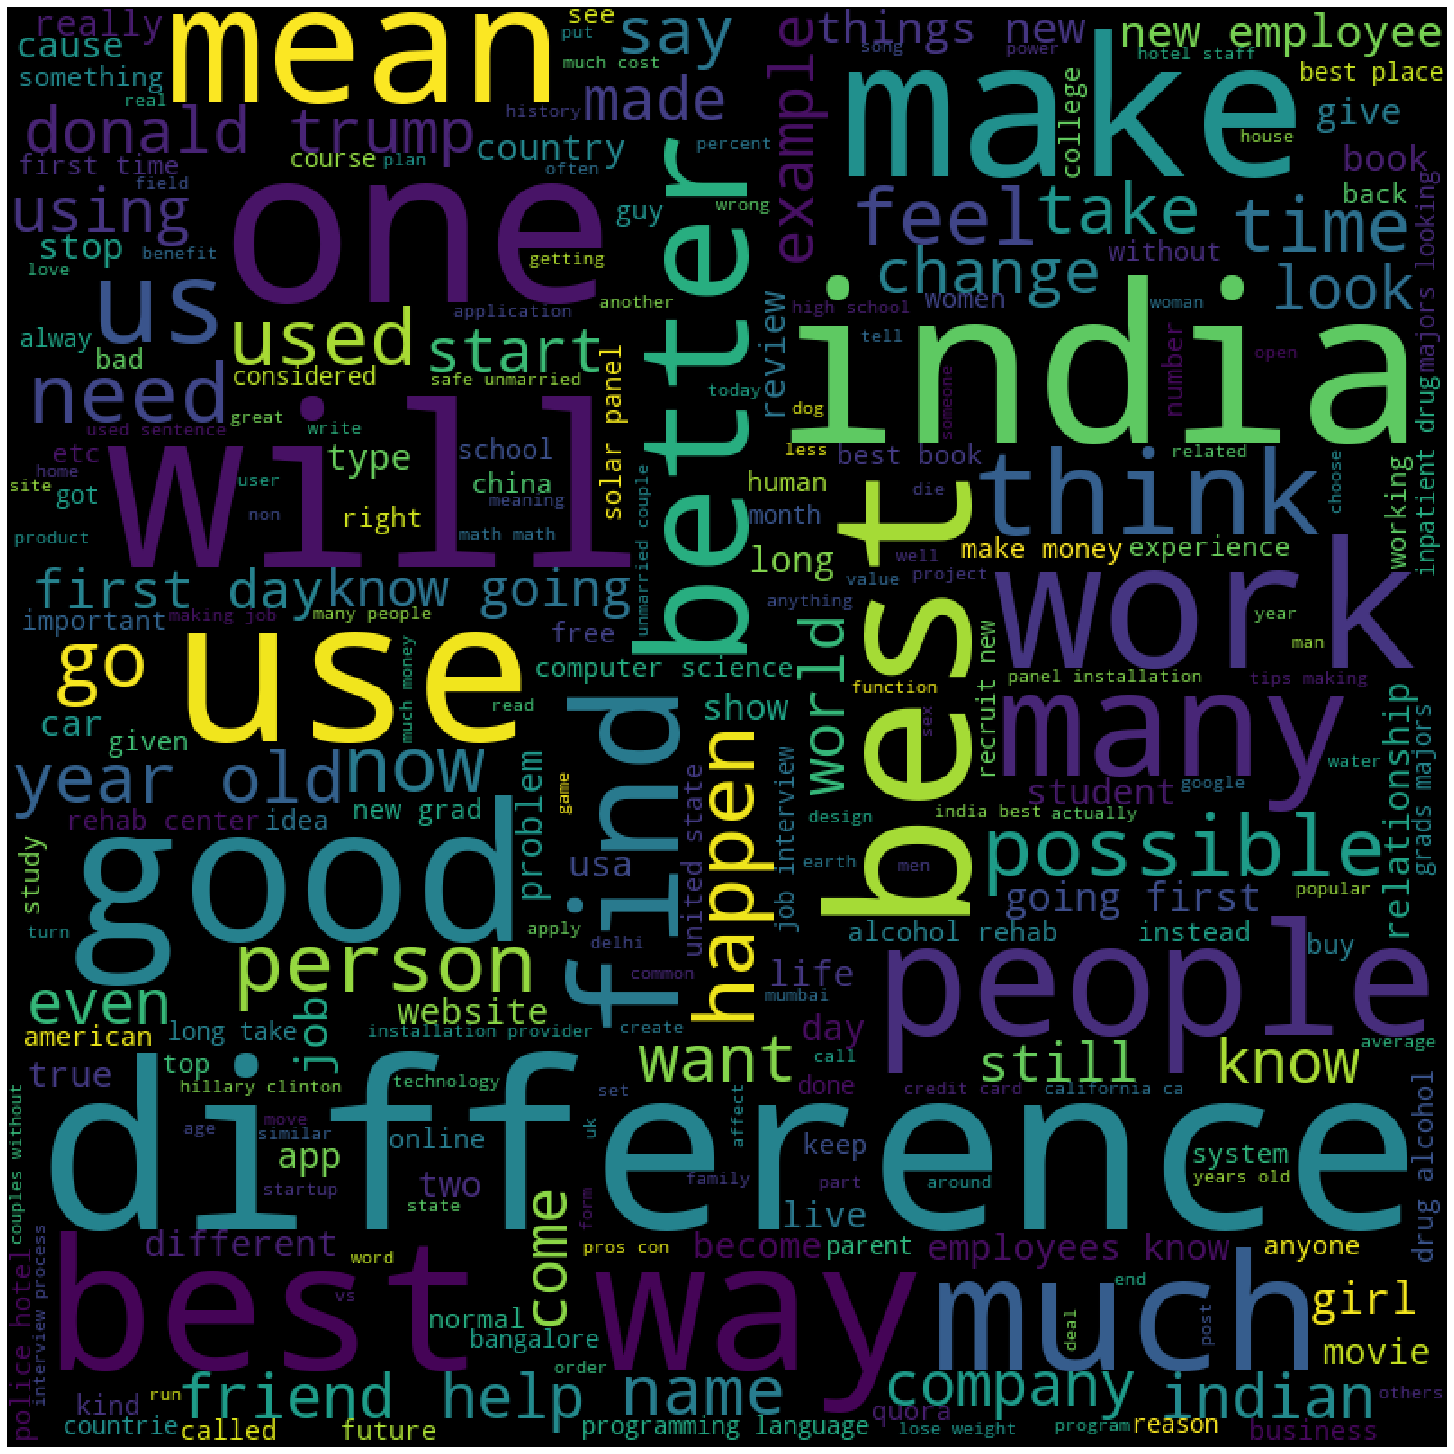

In [53]:
wc = WordCloud(width = 800, height = 800, background_color="black", min_font_size = 10, max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wc)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

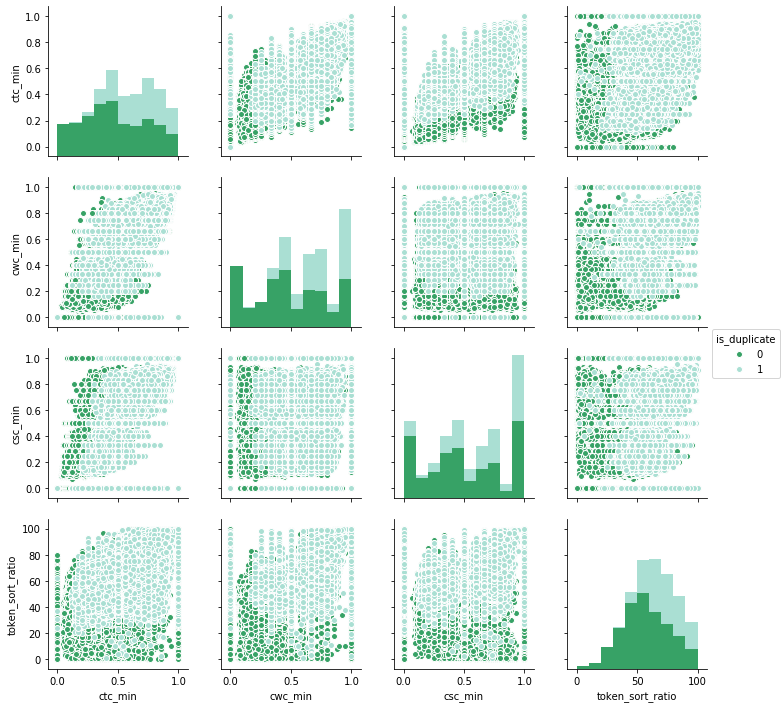

In [54]:
n = df_final.shape[0]
sns.pairplot(df_final[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'], palette='BuGn_r')
plt.show()

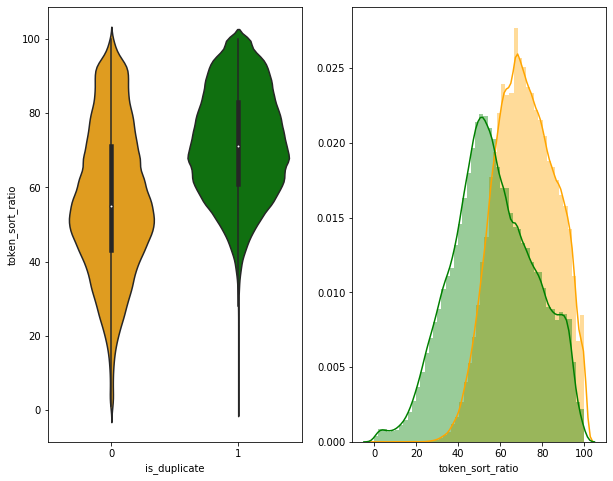

In [55]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df_final[0:], palette=['orange', 'green'])

plt.subplot(1,2,2)
sns.distplot(df_final[df_final['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'orange')
sns.distplot(df_final[df_final['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'green' )
plt.show()

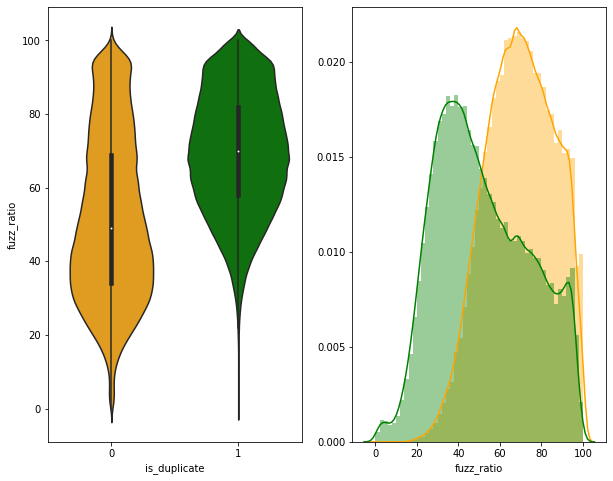

In [56]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df_final[0:], palette=['orange', 'green'])

plt.subplot(1,2,2)
sns.distplot(df_final[df_final['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'orange')
sns.distplot(df_final[df_final['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'green' )
plt.show()

### Visualization

In [57]:
dfp_subsampled = df_final[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', \
                                                 'ctc_max' , 'last_word_eq', 'first_word_eq', 'abs_len_diff', \
                                                 'mean_len', 'token_set_ratio', 'token_sort_ratio', \
                                                 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [58]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

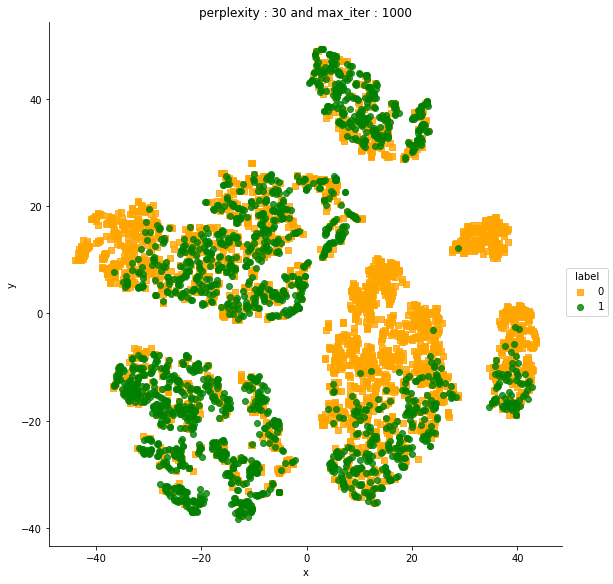

In [59]:
dftsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=dftsne, x='x', y='y', hue='label', fit_reg=False, size=8,palette=['orange', 'green'], markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [60]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

In [61]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color=y,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        line=dict(color='rgb(255, 255, 255)'),
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## 9. Featurizing text data with TFIDF


In [62]:
# encode questions to unicode
# https://stackoverflow.com/a/6812069
df_final['clean_question1'] = df_final['clean_question1'].apply(lambda x: str(x))
df_final['clean_question2'] = df_final['clean_question2'].apply(lambda x: str(x))

In [63]:
df_final.head(2)

,id,qid1,qid2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,1,1,66,57,14,12,10.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,4,1,51,88,8,13,4.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [66]:
df_final = df_final[:100000]

In [67]:
df_final.shape

(100000, 32)

### Splitting into Train and Test

In [68]:
y = df_final['is_duplicate'].values
df_final.drop(['is_duplicate'], axis='columns', inplace=True)
X = df_final

In [69]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### TFIDF Vectorization

In [71]:
vectorizer_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000)
def TFIDF_Vectorization(train_column, test_column):
    vectorizer_tfidf.fit(train_column)
    X_train_tfidf = vectorizer_tfidf.transform(train_column)
    X_test_tfidf = vectorizer_tfidf.transform(test_column)
    return (X_train_tfidf, X_test_tfidf)

In [72]:
tra1 = X_train['clean_question1'].values
tes1 = X_test['clean_question1'].values
X_train_question1_tfidf, X_test_question1_tfidf = TFIDF_Vectorization(tra1, tes1)
print("After vectorizations")
print(X_train_question1_tfidf.shape, y_train.shape)
print(X_test_question1_tfidf.shape, y_test.shape) 
print("="*100)

After vectorizations
(70000, 5000) (70000,)
(30000, 5000) (30000,)


In [73]:
tra2 = X_train['clean_question2'].values
tes2 = X_test['clean_question2'].values
X_train_question2_tfidf, X_test_question2_tfidf = TFIDF_Vectorization(tra2, tes2)
print("After vectorizations")
print(X_train_question2_tfidf.shape, y_train.shape)
print(X_test_question2_tfidf.shape, y_test.shape) 
print("="*100)

After vectorizations
(70000, 5000) (70000,)
(30000, 5000) (30000,)


### Loading GloVe

In [46]:
# storing variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### TFIDF weighted W2V vectorization

In [47]:
def tfidf_w_w2v_fit(column):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(column)
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    return (tfidf_words, dictionary)

In [48]:
def tfidf_w_w2v_vectorization(column):
    tfidf_words, dictionary = tfidf_w_w2v_fit(column)
    tfidf_w2v_vectors_lst = list()
    for sentence in tqdm(column):
        vector = np.zeros(300)
        tf_idf_weight = 0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_lst.append(vector)
    return array(tfidf_w2v_vectors_lst)

In [51]:
from numpy import array

In [52]:
tra3 = X_train['clean_question1'].values
X_train_question1_tfidf_w2v = tfidf_w_w2v_vectorization(tra3)  
tes3 = X_test['clean_question1'].values
X_test_question1_tfidf_w2v = tfidf_w_w2v_vectorization(tes3)
print("After vectorizations")
print(X_train_question1_tfidf_w2v.shape, y_train.shape)
print(X_test_question1_tfidf_w2v.shape, y_test.shape) 
print("="*100)

100%|██████████| 30000/30000 [00:01<00:00, 19037.99it/s]


After vectorizations
(70000, 300) (70000,)
(30000, 300) (30000,)


In [54]:
tra4 = X_train['clean_question2'].values
X_train_question2_tfidf_w2v = tfidf_w_w2v_vectorization(tra4)
tes4 = X_test['clean_question2'].values
X_test_question2_tfidf_w2v = tfidf_w_w2v_vectorization(tes4)
print("After vectorizations")
print(X_train_question2_tfidf_w2v.shape, y_train.shape)
print(X_test_question2_tfidf_w2v.shape, y_test.shape) 
print("="*100)

100%|██████████| 30000/30000 [00:01<00:00, 19136.67it/s]


After vectorizations
(70000, 300) (70000,)
(30000, 300) (30000,)


### Dropping string type data from DataFrame

In [74]:
X_train.drop(['clean_question1', 'clean_question2'], axis='columns', inplace=True)
X_test.drop(['clean_question1', 'clean_question2'], axis='columns', inplace=True)

### Converting to sparse matrix

In [75]:
X_tr_tfidf = hstack((X_train, X_train_question1_tfidf, X_train_question2_tfidf)).tocsr()
X_test_tfidf = hstack((X_test, X_test_question1_tfidf, X_test_question2_tfidf)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(70000, 10029) (70000,)
(30000, 10029) (30000,)


In [56]:
X_tr_tfidf_w2v = hstack((X_train, X_train_question1_tfidf_w2v, X_train_question2_tfidf_w2v)).tocsr()
X_test_tfidf_w2v = hstack((X_test, X_test_question1_tfidf_w2v, X_test_question2_tfidf_w2v)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(70000, 629) (70000,)
(30000, 629) (30000,)


### Storing results in pickle variable

In [76]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
with open('tfidf.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf, y_train, X_test_tfidf, y_test], f)

In [57]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
with open('tfidf_w2v.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test], f)

In [77]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
with open('tfidf.pickle', 'rb') as f:
    X_tr_tfidf, y_train, X_test_tfidf, y_test =  pickle.load(f)

In [58]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test =  pickle.load(f)

In [78]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len)
print("Class 1: ", int(train_distr[1])/train_len)

print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len)
print("Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6265714285714286
Class 1:  0.37342857142857144
---------- Distribution of output variable in test data ----------
Class 0:  0.6295333333333333
Class 1:  0.37046666666666667


## 10. Functions used in TFIDF based vectorized data

### Plotting Binary Confusion, Precision & Recall Matrices

In [44]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    
    cmap=sns.light_palette("orange")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Random Model

Log loss on Test Data using Random Model 0.8908087267599577


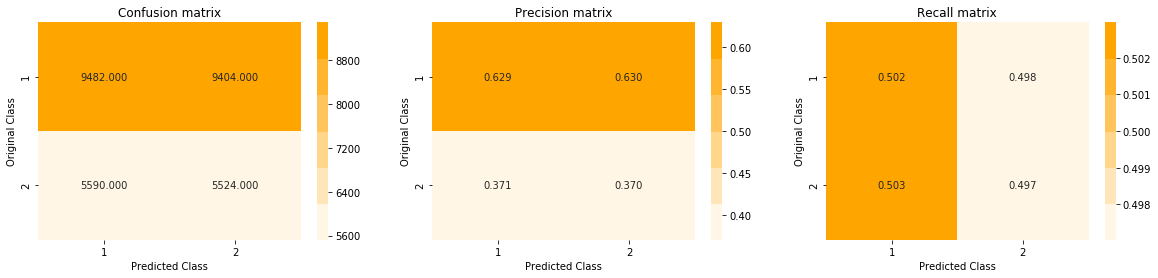

In [80]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression Hyperparameter Tuning

For values of alpha =  1e-05 The log loss is: 0.6592224863203546
For values of alpha =  0.0001 The log loss is: 0.6592224863203546
For values of alpha =  0.001 The log loss is: 0.6592224863203546
For values of alpha =  0.01 The log loss is: 0.6592224863203546
For values of alpha =  0.1 The log loss is: 0.5814420809606712
For values of alpha =  1 The log loss is: 0.5728942189867778
For values of alpha =  10 The log loss is: 0.5986263431788207


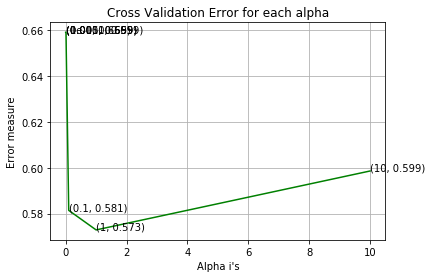

For values of best alpha =  1 The train log loss is: 0.5752807813532447
For values of best alpha =  1 The test log loss is: 0.5728942189867778
Total number of data points : 30000


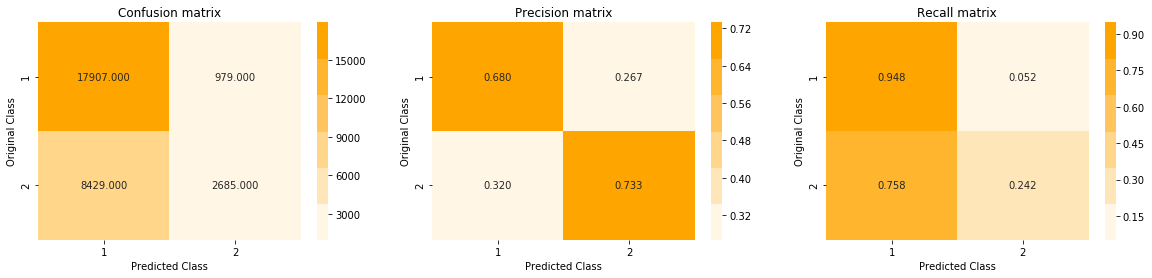

In [83]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, n_jobs=-1)
    clf.fit(X_tr_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, n_jobs=-1)
clf.fit(X_tr_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_tr_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM Hyperparameter Tuning

For values of alpha =  1e-05 The log loss is: 0.6592224863203546
For values of alpha =  0.0001 The log loss is: 0.6592224863203546
For values of alpha =  0.001 The log loss is: 0.6592224863203546
For values of alpha =  0.01 The log loss is: 0.6592224863203546
For values of alpha =  0.1 The log loss is: 0.6592224863203546
For values of alpha =  1 The log loss is: 0.5964710882339009
For values of alpha =  10 The log loss is: 0.6512596616204426


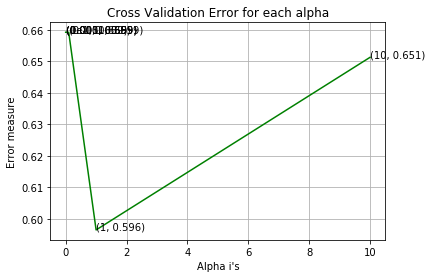

For values of best alpha =  1 The train log loss is: 0.5986940317219764
For values of best alpha =  1 The test log loss is: 0.5964710882339009
Total number of data points : 30000


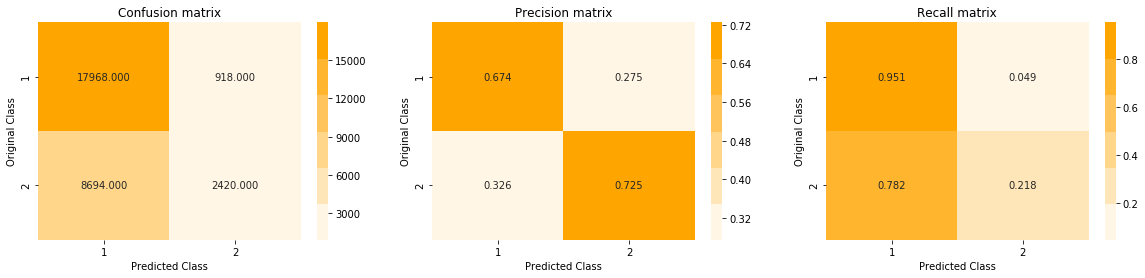

In [84]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_tr_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_tr_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_tr_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 11. Functions used in TFIDF-W2V based vectorized data

In [6]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test =  pickle.load(f)

In [3]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6272 Class 1:  0.3728
---------- Distribution of output variable in train data ----------
Class 0:  0.37193333333333334 Class 1:  0.37193333333333334


In [5]:
parameters_gbdt = {}
parameters_gbdt['max_depth'] = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parameters_gbdt['n_estimators'] = [5, 10, 50, 100, 200, 500, 1000]
parameters_gbdt['objective'] = ['binary:logistic']
parameters_gbdt['eval_metric'] = ['logloss']
parameters_gbdt['eta'] = [0.02]
print(parameters_gbdt)

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'eval_metric': ['logloss'], 'eta': [0.02], 'objective': ['binary:logistic']}


In [6]:
def hparameter_tuning_xgb(X_tr_data, y_train_data, filename):
    
    xgb = xgbc(n_jobs=-1)
    
    clf = GridSearchCV(estimator=xgb, param_grid=parameters_gbdt, cv=3, scoring='neg_log_loss', n_jobs=-1)
    
    clf.fit(X_tr_data, y_train_data)
    results = clf.cv_results_
    best_hyperparameter = clf.best_params_
    best_score = clf.best_score_
    best_estimator = clf.best_estimator_
    
    with open(filename, 'wb') as f:
        pickle.dump([results, best_hyperparameter, best_score, best_estimator] , f)

In [7]:
from xgboost import XGBClassifier as xgbc
hparameter_tuning_xgb(X_tr_tfidf_w2v, y_train, 'xgboost_results.pickle')

In [3]:
with open('xgboost_results.pickle', 'rb') as f:
    results, best_hyperparameter, best_score, best_estimator = pickle.load(f)

In [4]:
print('Best hyperparameter is: '+str(best_hyperparameter))
print('Best score is: '+ str(best_score))

Best hyperparameter is: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'n_estimators': 200, 'eta': 0.02, 'max_depth': 7}
Best score is: -0.33205988590527413


In [6]:
params = best_hyperparameter
d_train = xgb.DMatrix(X_tr_tfidf_w2v, label=y_train)
d_test = xgb.DMatrix(X_test_tfidf_w2v, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_tr_tfidf_w2v, y_train)
predict_y = bst.predict(d_test)

with open('best_xgb_result.pickle', 'wb') as f:
        pickle.dump([predict_y] , f)

[0]	train-logloss:0.683324	valid-logloss:0.683499
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.603148	valid-logloss:0.605004
[20]	train-logloss:0.545524	valid-logloss:0.549094
[30]	train-logloss:0.502277	valid-logloss:0.50745
[40]	train-logloss:0.469018	valid-logloss:0.475745
[50]	train-logloss:0.443079	valid-logloss:0.451381
[60]	train-logloss:0.422008	valid-logloss:0.432162
[70]	train-logloss:0.404966	valid-logloss:0.416658
[80]	train-logloss:0.391086	valid-logloss:0.404196
[90]	train-logloss:0.37959	valid-logloss:0.394151
[100]	train-logloss:0.369897	valid-logloss:0.3859
[110]	train-logloss:0.361976	valid-logloss:0.379343
[120]	train-logloss:0.355428	valid-logloss:0.373992
[130]	train-logloss:0.349658	valid-logloss:0.36953
[140]	train-logloss:0.344474	valid-logloss:0.365721
[150]	train-logloss:0.339879	valid-logloss:0.362323
[160]	train-logloss:0.336098	vali

In [4]:
with open('best_xgb_result.pickle', 'rb') as f:
    predict_y = pickle.load(f)

In [38]:
predicted_y = np.array(predict_y)
predicted_y = predicted_y.reshape(30000)

Total number of data points : 30000


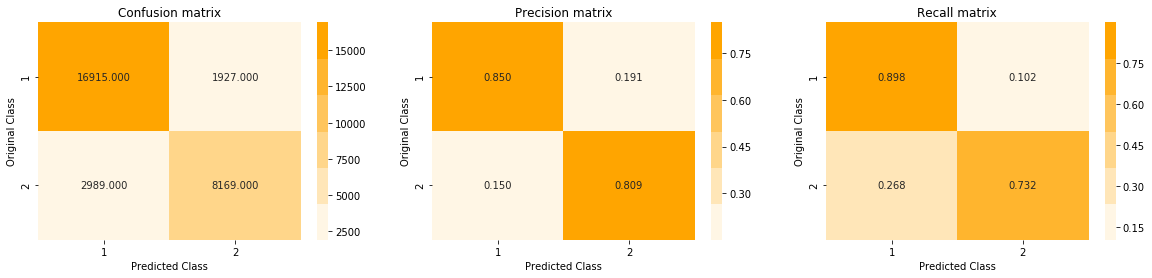

In [45]:
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y.round())

# Conclusion

In [47]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "logloss (Test)"]
x.add_row(['TFIDF', 'Random Model', '0.8908'])
x.add_row(['TFIDF', 'Logistic Regression', '0.5728'])
x.add_row(['TFIDF', 'Linear SVM', '0.5964'])
x.add_row(['TFIDF W2V', 'XGBoost', '0.3335'])
print(x)

+------------+---------------------+----------------+
| Vectorizer |        Model        | logloss (Test) |
+------------+---------------------+----------------+
|   TFIDF    |     Random Model    |     0.8908     |
|   TFIDF    | Logistic Regression |     0.5728     |
|   TFIDF    |      Linear SVM     |     0.5964     |
| TFIDF W2V  |       XGBoost       |     0.3335     |
+------------+---------------------+----------------+


# Summary

logloss has improved considerably using Logistic Regression as compared to the Random Model on TFIDF vectorized data. But using another model, results were not that good (Linear SVM), it increased. So Best log loss for Test in case of TFIDF vectorized data was for Logistic Regression only.

For XGBoost on TFIDF W2V, test log loss was observed to be the lowest.